# Predictive mediation analysis

This notebook shows how to conduct predictive mediation analyses with general SHAP values.

In this example, we ask why the mean radius and mean area of breast cancer tumors predict whether the tumor is malignant. We find that the relationship is partly explained by mean area itself, and partly by 'mediators' such as worst perimeter.

This question is a specific example of a general question. Suppose we have two models, $f_X:X\mapsto y$ and $f_{XZ}:X\times Z\mapsto y$. We can ask why, according to our model $f_{XZ}$, $X$ is related to $y$ in model $f_X$.

We can think of this as a *predictive mediation analysis*. $f_X$ estimates the total relationship between $X$ and $y$. $f_{XZ}$ estimates the relationship between the 'independent variables' and 'mediators' ($X$ and $Z$) and $y$. The G-SHAP values for $X$ estimate the direct relationship between $X$ and $y$, while the G-SHAP values for $Z$ estimate the indirect relationship between $X$ and $y$ through $Z$.

Here, the independent variables $X$ are mean radius and mean area, the target variable $y$ indicates that the tumor is benign (as opposed to malignant), and the mediators $Z$ are other variables in the dataset such as perimeter and texture.

**Note**. 'Independent variables' and 'mediators' do not necessarily refer to causal relationships in this context.

In [1]:
import warnings
warnings.simplefilter('ignore')

import gshap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score

np.random.seed(0)

We begin by loading the Wisconsin breast cancer dataset and training our classifiers. $f_{XZ}$ uses both the independent variables $X$ and mediators $Z$, while $f_X$ uses only the independent variables $X$.

In [2]:
breast_cancer = load_breast_cancer()
XZ, y = breast_cancer.data, breast_cancer.target
independent_vars = [0,3]
X = XZ[:,independent_vars]

f_XZ = LogisticRegression(class_weight='balanced').fit(XZ, y)
print('Accuracy of f_XZ: %.4f' % balanced_accuracy_score(y, f_XZ.predict(XZ)))

f_X = LogisticRegression(class_weight='balanced').fit(X, y)
print('Accuracy of f_X: %.4f' % balanced_accuracy_score(y, f_X.predict(X)))

Accuracy of f_XZ: 0.9408
Accuracy of f_X: 0.8595


Next, we look at the relationship between one of our independent variables and worst perimeter. We can see that our independent variables are related to worst perimeter. Additionally, our independent variables and worst perimeter are related to the target variable, malignancy. 

From visual inspection, it is possible that the relationship between our independent variables and malignancy is explained by mediators such as worst perimeter.

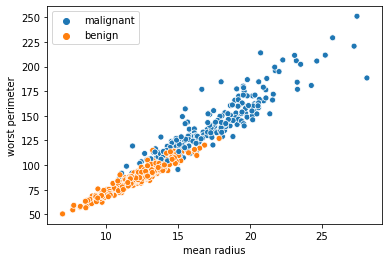

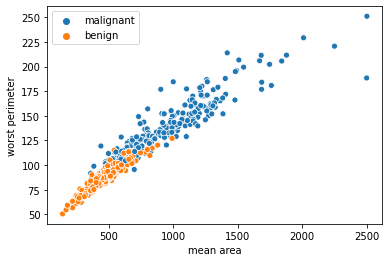

In [3]:
df = pd.DataFrame(columns=breast_cancer.feature_names, data=XZ)
labels = [breast_cancer.target_names[y_i] for y_i in y]
for i in independent_vars:
    sns.scatterplot(df[breast_cancer.feature_names[i]], df['worst perimeter'], hue=labels)
    plt.show()

Compute the G-SHAP values, where $g$ measures the relationship between $f_X(X)$ and $f_{XZ}(X,Z)$. To the extent that $f_{XZ}(X,Z)$ is a good estimate of $y$, we can think of $g$ as measuring the relationship between $X$ and $y$ in model $f_X$.

Here, the relationship between $f_X(X)$ and $f_{XZ}(X,Z)$ is the accuracy with which $f_X(X)$ predicts $f_{XZ}(X,Z)$. Because the `KernelExplainer` estimates G-SHAP values by feeding partly shuffled data into $f_{XZ}$, it is best practice to re-estimate $f_X$ in $g$.

In [4]:
def g(y_pred_XZ):
    f_X = LogisticRegression(class_weight='balanced').fit(X, y_pred_XZ)
    return balanced_accuracy_score(y_pred_XZ, f_X.predict(X))
explainer = gshap.KernelExplainer(f_XZ.predict, XZ, g)
gshap_values = explainer.gshap_values(XZ, nsamples=100)

For interpretation, we compare our data $X\cup Z$ to the shuffled background data $X_b\cup Z_b$ in terms of $g$.

We see that $f_X(X)$ accurately predicts $f_{XZ}(X,Z)$. As expected, $f_X(X)$ more accurately predicts $f_{XZ}(X,Z)$ than it does $y$. Also as expected, $f_X(X)$ predicts $f_{XZ}(X_b,Z_b)$ at chance.

The sum of the G-SHAP values should approximately equal the difference in $f_X(X)$'s accuracy in predicting $f_{XZ}(X,Z)$ and its accuracy in predicting $f_{XZ}(X_b,Z_b)$, allowing for sampling error.

In [5]:
g_comparison, g_background = explainer.compare(XZ, bootstrap_samples=100)
print('Accuracy of x variables in predicting classifier predictions: %.4f' % g_comparison)
print('Accuracy of x variables in predicting classifier predictions of shuffled background data: %.4f' % g_background)
print('Sum of G-SHAP values: %.4f' % gshap_values.sum())

Accuracy of x variables in predicting classifier predictions: 0.8670
Accuracy of x variables in predicting classifier predictions of shuffled background data: 0.5183
Sum of G-SHAP values: 0.3244


Finally, we plot our results. This plot tells us the extent to which each variable explains the relationship between $X$ and $y$ in model $f_X$, according to model $f_{XZ}$.

More precisely, $f_X(X)$ predicts the output of $f_{XZ}(X,Z)$ with accuracy $p$, and the output of $f_{XZ}(X_b,Z_b)$ with accuracy $p_b$. Each G-SHAP value $\phi_j$ is the amount of this difference $p-p_b$ explained by feature $j$ for each $j\in X\cup Z$.

To the extent $f_{XZ}(X,Z)$ is a good estimate of $y$, we can interpret $p$ as the accuracy with which $f_X(X)$ predicts $y$. We can interpret each G-SHAP value $\phi_j$ as the extent to which the relationship between $X$ and $y$ in model $f_X$ is explained by feature $j$.

Because $f_{XZ}(X,Z)$ is just an estimate of $y$, we rescale the G-SHAP values appropriately to reflect that $f_X(X)$ predicts $y$ less accurately than it does $f_{XZ}(X,Z)$.

We see that part of the relationship between our independent variables, mean radius and mean area, and malignancy, is due to mean area itself. None of the relationship is due to mean radius. Mediating variables, most importantly worst perimeter, are more important in explaining the relationship between the independent variables and target variable than the independent variables themselves.

Amount of the accuracy of $f_X(X)$ on $y$ explained by feature $j$ for $j\in X\cup Z$.

In [6]:
gshap_values *= (balanced_accuracy_score(y, f_X.predict(X)) - g_background) / (g_comparison - g_background)

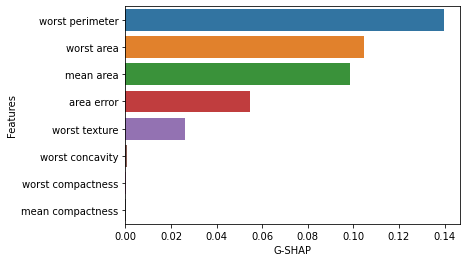

In [7]:
df = pd.DataFrame({'Features': breast_cancer.feature_names, 'G-SHAP': gshap_values})
df = df.sort_values('G-SHAP', ascending=False)[:8]
sns.barplot(y='Features', x='G-SHAP', data=df)
plt.show()

# Relationship to mediation in linear causal models (sanity check)

Here we use simulated data for a causal mediation relationship. 

$\gamma=0\implies$ $X$ is not related to $Z$, so the relationship is not mediated by $Z$.

$\sigma_z=0\implies$ $X$ and $Z$ are perfectly collinear, so the relationship between $X$ and $y$ is equally due to $X$ and $Z$.

$\beta_X=0\implies$ $X$ is not directly related to $y$, so the relationship is fully mediated by $Z$.

$\beta_Z=0\implies$ $Z$ is not related to $y$, so the relationship is not mediated by $Z$.

In [8]:
size = (1000,1)

gamma = 1
sigma_z = 1
beta_x = 1
beta_z = 0
sigma_y = 1

X = np.random.normal(size=size)
Z = gamma*X + np.random.normal(scale=sigma_z, size=size)
y = beta_x*X + beta_z*Z + np.random.normal(scale=sigma_y, size=size)
XZ = np.concatenate((X,Z), axis=1)

In [9]:
from sklearn.linear_model import LinearRegression

reg_XZ = LinearRegression().fit(XZ, y)
reg_X = LinearRegression().fit(X, y)

print(reg_XZ.score(XZ, y))
print(reg_X.score(X, y))

0.5277099704901085
0.5275720744750676


In [10]:
def g(y_pred):
    return LinearRegression().fit(X, y_pred).score(X, y_pred)
explainer = gshap.KernelExplainer(reg_XZ.predict, XZ, g)
gshap_values = explainer.gshap_values(XZ, nsamples=1000)
gshap_values

array([9.98544658e-01, 2.75559584e-04])

In [11]:
g_comparison, g_background = explainer.compare(XZ, bootstrap_samples=100)
print(g_comparison, g_background)
print(g_comparison-g_background)
print(gshap_values.sum())

0.9997386897675764 0.001032094674018721
0.9987065950935576
0.998820217120198


In [12]:
gshap_values *= (reg_X.score(X,y) - g_background) / (g_comparison - g_background)
print(gshap_values)
print(gshap_values.sum())

[5.26454603e-01 1.45281045e-04]
0.5265998838208141
